In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

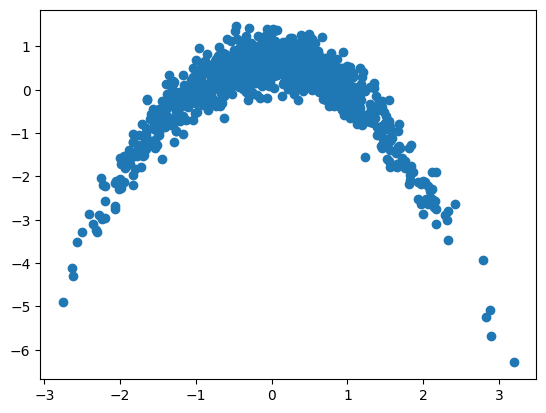

In [2]:
#target distribution q_D
N=1000
Xs = np.random.randn(2*N).reshape(N,2)
Xs[:,1]-= 2*Xs[:,0]**2
#it is alweays a good idea for diffusion to normalize data to zero mean, unit variance
Xs = (Xs - np.mean(Xs,axis=0).reshape(1,-1))/np.std(Xs,axis=0).reshape(1,-1)
plt.figure()
plt.scatter(Xs[:,0],Xs[:,1])
plt.show()

In [3]:
#neural network to learn epsilon(x_t,t). you can play around with it, but we added it for convenience
#note that this networks expects normalized values of t in 0 to 1. so divide your time index by T.
class Net(nn.Module):
    def __init__(self, num_latent_features=32, num_embedding_features=16):
        super().__init__()
        self.num_embedding_features=num_embedding_features
        self.num_latent_features = num_latent_features
        self.fc_in = nn.Linear(2, num_latent_features)
        self.fc_emb = nn.Linear(num_embedding_features, num_latent_features)
        self.fc1 = nn.Linear(num_latent_features, num_latent_features)
        self.fc2 = nn.Linear(num_latent_features, num_latent_features)
        self.fc_out = nn.Linear(num_latent_features, 2)

    def embedding(self, t):
        #We assume that t is a n-dimensional vector with values in [0,1]
        #each element in t gives the time for each element in the batch
        num_frequencies = self.num_embedding_features // 2
        frequencies = torch.logspace(0,3,num_frequencies,device=t.device, dtype=t.dtype)
        cos_feats = torch.cos(2*np.pi*frequencies.unsqueeze(0)*t.unsqueeze(1))
        sin_feats = torch.sin(2*np.pi*frequencies.unsqueeze(0)*t.unsqueeze(1))
        return torch.hstack([cos_feats,sin_feats])
        
    def forward(self, x,t):
        t_embedding = self.embedding(t)
        #Create sinusoidal features and apply the silu activation
        t_embedding = torch.nn.functional.silu(self.embedding(t))

        #linear combination of space and time features
        x = F.silu(self.fc_in(x) + self.fc_emb(t_embedding))
        #now apply a simple feed forward network with relu activations.
        #note: we skip dropout for simplicity.
        x = F.silu(self.fc1(x))
        x = F.silu(self.fc2(x))
        #transform back
        x = self.fc_out(x)
        return x

In [ ]:
#Task 1: for the given set of T and beta plot the generating distribution q(X_t) for different t=0,30,60,100
#As beta we use the scheme proposed in the lecture
T=100
ts = np.linspace(0,1,T+1)
s=0.08
gs=np.cos(np.pi/2*((ts+s)/(1+s)))**2
betas = np.minimum(1- gs[1:]/gs[:-1],0.999)
#simpler scheme with fixed beta for comparison
#betas = 0.05*np.ones(T)

def OU(ts:np.ndarray, theta:float, sigma:float, betas:np.ndarray) -> np.ndarray:
    """ 
    Ornstein-Uhlenbeck process for given time steps ts
    """
    fs = np.array([np.random.normal(0,sigma)])
    for i in range(1,len(ts)):
        a_i = np.exp(-theta*(ts[i]-ts[i-1]))
        epsilon_i = np.random.normal(0,((1 - a_i**2)*sigma**2)**2)
        f_i = a_i*fs[i-1] + epsilon_i * betas[i-1]
        fs = np.append(fs, f_i)
    return fs

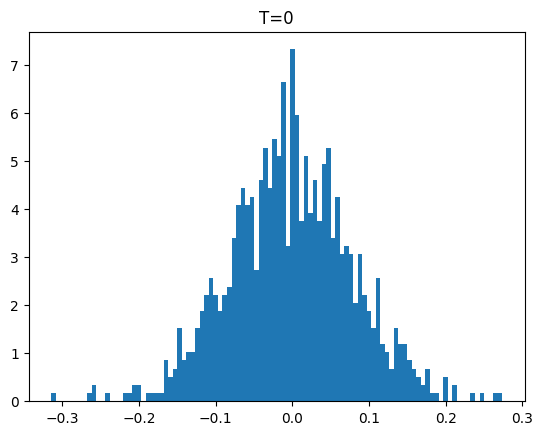

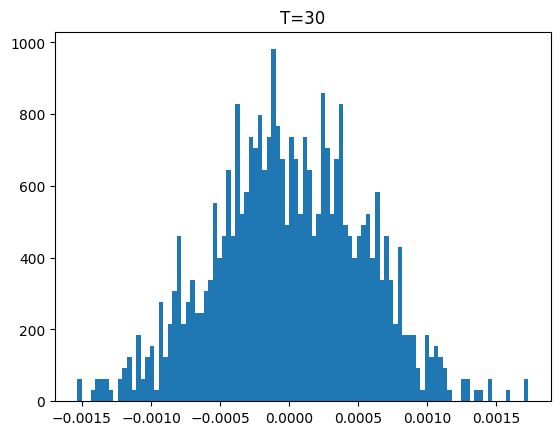

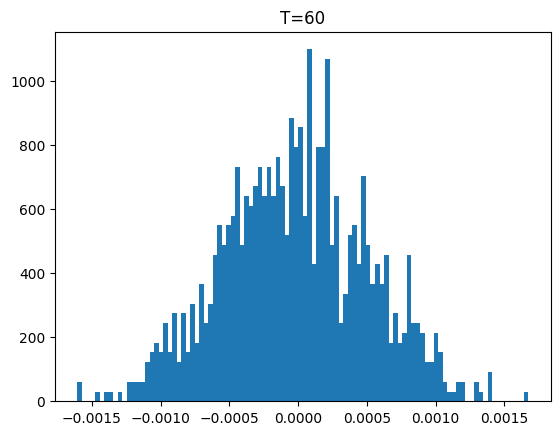

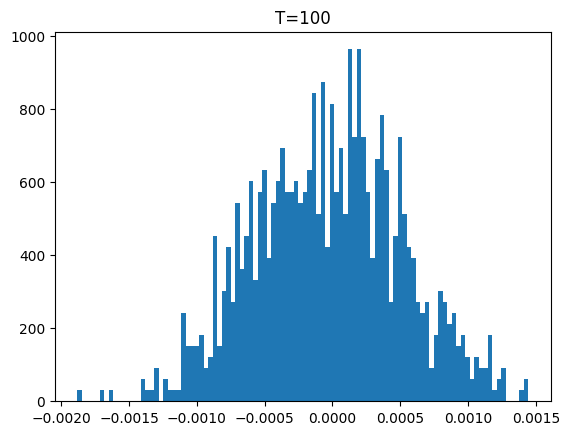

In [5]:
for t in [0,30,60,100]:
    ts = np.linspace(0,1,t+1)
    gs=np.cos(np.pi/2*((ts+s)/(1+s)))**2
    betass = np.minimum(1- gs[1:]/gs[:-1],0.999)
    qs = np.array([])
    for i in range(1000):
      qs = np.append(qs, OU(ts,5, s, betass)[-1])
    plt.hist(qs, bins=100, density=True)
    plt.title(f'T={t}')
    plt.show()

In [ ]:
model = Net()
betas = betas / T

device = next(model.parameters()).device
betas = torch.tensor(betas, dtype=torch.float32, device=device)
#betas = torch.linspace(1e-4, 0.02, T, device=device)

In [7]:
#Task 2: implement the loss function for gradient descent (eq 76 in th script, or L_simple in the background material)
#implement by sampling a random time step t in 0,..,T
#params: 
#    Xs: a batch of samples from the dataset.
#    model: the model for learning epsilon.
def loss (Xs:np.ndarray, model:nn.Module) -> torch.Tensor:
    # sample random time step t
    t = torch.max(
        torch.randint(0, len(Xs), size=(1,), device=Xs.device), 
        torch.tensor([1], device=Xs.device)
    )
    # sample X_0 from data
    x_0 = Xs[torch.randint(0, len(Xs), size=(1,), device=Xs.device)]
    # sample epsilon from standard normal
    epsilon = torch.normal(torch.tensor(0.0),torch.tensor(1.0))
    # compute alpha bar
    alpha = torch.cumprod(1 - (betas[:t]), dim=0)[-1]

    # compute loss
    part_1 = torch.sqrt(alpha)*x_0
    part_2 = torch.sqrt(1-alpha)*epsilon
    loss = F.mse_loss(epsilon,model(part_1 + part_2, t))
    return loss

In [8]:
#Task 2: implement the loss function for gradient descent (eq 76 in th script, or L_simple in the background material)
#implement by sampling a random time step t in 0,..,T
#params: 
#    Xs: a batch of samples from the dataset.
#    model: the model for learning epsilon.

def loss(Xs: torch.Tensor, model: nn.Module) -> torch.Tensor:
    batch_size = Xs.shape[0]

    # sample t uniformly
    t = torch.randint(0, T, (batch_size,), device=Xs.device)
    # sample epsilon_t from standard normal
    eps_t = torch.randn_like(Xs)

    # ᾱ_t
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    alpha_bar = alphas_cumprod[t].to(Xs.device).view(-1, 1)

    # x_t = √ᾱ_t x_0 + √(1-ᾱ_t) ε
    x_t = torch.sqrt(alpha_bar) * Xs + torch.sqrt(1.0 - alpha_bar) * eps_t

    # normalize time to [0, 1]
    t_norm = t / (T - 1)
    eps_theta = model(x_t, t_norm)

    return F.mse_loss(eps_theta, eps_t)

In [9]:
#train loop. added for your convenience.
train_loader = torch.utils.data.DataLoader(torch.tensor(Xs,dtype=torch.float32), batch_size=10)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()
num_epochs = 100
for e in range(num_epochs):
    for data in train_loader:
        optimizer.zero_grad()
        l = loss(data,model) 
        l.backward()
        optimizer.step()
    if e % (num_epochs//10) == 0:
        print("epoch:",e)
        print(f'loss: {l.item()}')

epoch: 0
loss: 0.7278674840927124
epoch: 10
loss: 1.0725786685943604
epoch: 20
loss: 0.7983380556106567
epoch: 30
loss: 0.6851662397384644
epoch: 40
loss: 0.5876255035400391
epoch: 50
loss: 0.8524573445320129
epoch: 60
loss: 0.6313134431838989
epoch: 70
loss: 1.129022240638733
epoch: 80
loss: 1.0677109956741333
epoch: 90
loss: 0.9920405149459839


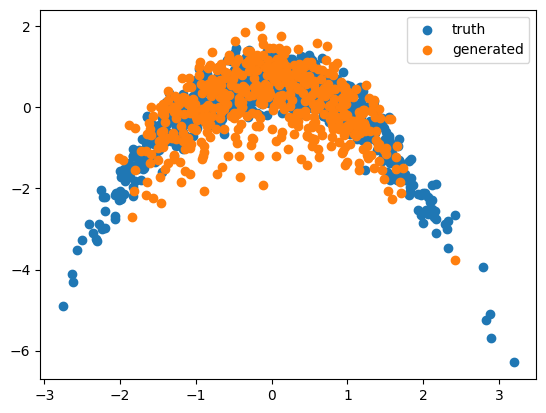

In [10]:
#Task 3: generate samples from the learned model
#num: number of samples to generate
#model: the trained model
def generate_samples(model:nn.Module, num:int) -> torch.Tensor:
    model.eval()
    with torch.no_grad():
        # Start with pure noise x_T ~ N(0, I)
        xt = torch.randn(num, 2, dtype=torch.float32)
        
        # Pre-calculate alpha values based on the betas defined earlier
        alphas = 1 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)

        xt_list = torch.zeros((T,num,2), dtype=torch.float32)

        for i in reversed(range(T)):

            part1 = 1 / torch.sqrt(1 - betas[i])
            part2 = (betas[i] / torch.sqrt(1 - alphas_cumprod[i]))
            epsilon = model(xt, torch.tensor([i], dtype=torch.float32))

            mu = part1 * (xt - part2 * epsilon)

            xt = torch.normal(mu, torch.sqrt(betas[i]))
            xt_list[i] = xt

    return xt_list[0]
            

samples = generate_samples(model,500).detach().numpy()

plt.figure()
plt.scatter(Xs[:,0],Xs[:,1],label="truth")
plt.scatter(samples[:,0],samples[:,1],label="generated")
plt.legend()
plt.show()